# 使用BERT辨識文章含意(分類)

## 前處理資料

In [1]:
import os


directory = []
file = []
title = []
text = []
label = []
datapath = 'bbc/'
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

### 把資料放進Dataframe

In [2]:
import pandas as pd


DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)),
                      columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,Quarterly profits at US media giant TimeWarn...,business
1,The dollar has hit its highest level against...,business
2,The owners of embattled Russian oil giant Yu...,business
3,British Airways has blamed high fuel prices ...,business
4,Shares in UK drinks and food firm Allied Dom...,business


In [3]:
df.shape

(2225, 2)

In [4]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
import numpy as np


for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
tech


<AxesSubplot:>

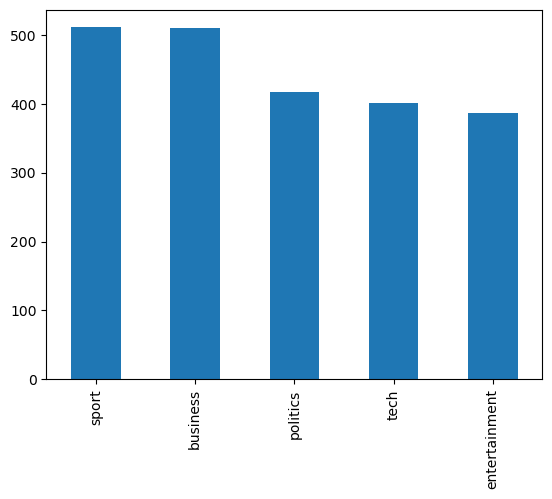

In [6]:
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

### Encoded Label

In [7]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.sample(5)

,text,label
731,"More than 1,000 people turned out on Sunday ...",1
769,Pop star Christina Aguilera is to marry musi...,1
598,"Irish actor Dan O'Herlihy, who was nominated...",1
456,German Chancellor Gerhard Schroeder has call...,0
739,Late R&B star Aaliyah's record company has f...,1


### 對文章內容前處理

In [8]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    #     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to /home/gunpow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.sample(3)

/tmp/ipykernel_4099/1063794143.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


,text,label
1244,gordon brown issued rallying cry supporters wa...,2
771,u three prestigious grammy awards hit vertigo ...,1
1974,term blog chosen top word us dictionary publi...,4


### 將文字轉換成BERT相容

In [10]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [11]:
df['text_split'] = df['text'].apply(get_split)
df.sample(3)

,text,label,text_split
1897,chinese netusing population looks set exceed u...,4,[chinese netusing population looks set exceed ...
1183,uk independence party lost one two london asse...,2,[uk independence party lost one two london ass...
249,profits chinese computer firm lenovo stood sti...,0,[profits chinese computer firm lenovo stood st...


In [12]:
import tensorflow as tf
# Set the output directory for saving model file
OUTPUT_DIR = 'results/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
    #         tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        pass

tf.io.gfile.mkdir(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

2022-09-05 11:16:42.789207: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


***** Model output directory: results/bert_news_category *****


In [13]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
train.sample(3)

,text,label,text_split
391,security firms warning windows virus disguisin...,4,[security firms warning windows virus disguisi...
459,double olympic champion hicham el guerrouj set...,3,[double olympic champion hicham el guerrouj se...
521,south korea boost state spending next year eff...,0,[south korea boost state spending next year ef...


In [14]:
# Get labels
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4]

In [15]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label,text_split
0,actor keanu reeves best known role matrix movi...,1,[actor keanu reeves best known role matrix mov...
1,labour party hold autumn conference mancheste...,2,[labour party hold autumn conference mancheste...


In [16]:
val.shape, train.shape

((445, 3), (1780, 3))

In [17]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(2171, 2171, 2171)

In [18]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(543, 543, 543)

In [19]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,crude oil prices surged back barrel mark thurs...,0
1,us rock band rem forced cancel concerts bass p...,1
2,chinese police detained three top executives m...,0
3,writing microsoft word document dangerous busi...,4
4,snow patrol course action ask cofounder bassis...,1


In [20]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,actor keanu reeves best known role matrix movi...,1
1,labour party hold autumn conference manchester...,2
2,us actor ossie davis found dead age davis marr...,1
3,computer firm apple issued lawsuit prevent onl...,4
4,labours leadership put show unity campaign pos...,2


## 製作BERT Data

In [23]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

ModuleNotFoundError: No module named 'transformers'

In [22]:
bert_preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
# bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

2022-09-05 11:16:46.375412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-05 11:16:46.400444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-05 11:16:46.400933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-05 11:16:46.401631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, r

FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on gunpow-surface. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                                text_a = x[DATA_COLUMN],
                                                                                text_b = None,
                                                                                label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                            text_a = x[DATA_COLUMN],
                                                                            text_b = None,
                                                                            label = x[LABEL_COLUMN]), axis = 1)